# Building simple popularity- and item-based recommendation functions

In [52]:
import pandas as pd
from pandas_profiling import ProfileReport
from thefuzz import process, fuzz
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
links = pd.read_csv('movie_data/links.csv')
movies = pd.read_csv('movie_data/movies.csv')
ratings = pd.read_csv('movie_data/ratings.csv')
tags = pd.read_csv('movie_data/tags.csv')

## Data Exploration 

In [35]:
#ProfileReport(links)

In [36]:
#ProfileReport(movies)

In [37]:
#ProfileReport(ratings)

In [38]:
ratings.groupby(by='movieId').rating.aggregate(func='count').median()

3.0

On average there are 10.4 ratings per movie with a median of 3.

In [39]:
#ProfileReport(tags)

array([[<AxesSubplot:title={'center':'userId'}>,
        <AxesSubplot:title={'center':'movieId'}>],
       [<AxesSubplot:title={'center':'rating'}>,
        <AxesSubplot:title={'center':'timestamp'}>]], dtype=object)

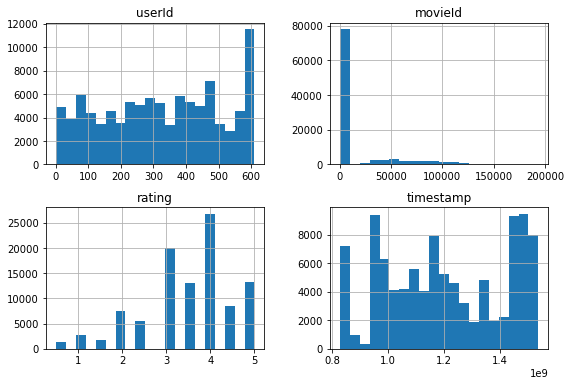

In [40]:
ratings.hist(bins=20, figsize=(9,6))

In [41]:
ratings.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

## Defining a score based on the number of ratings and their values 

In [65]:
ratings_scored = ratings.groupby(by='movieId').rating.aggregate(func=('mean','median','count'))
ratings_scored.rename(columns = {'mean':'avg_rating', 'median':'median_rating', 'count':'rating_count'}, inplace=True)
ratings_scored['popularity_scaler'] = (ratings_scored.rating_count - ratings_scored.rating_count.min())/ratings_scored.rating_count.max()
ratings_scored['scaled'] = ratings_scored.avg_rating*ratings_scored.popularity_scaler

Popularity scaled ratings would allow a movie with many bad ratings to reach a high score if many users have voted. Furthermore, this would prevent movies with only a few ratings (even if those are very good) from a decent score.

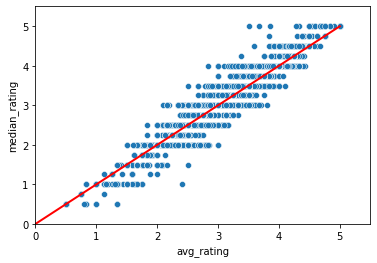

In [64]:
sns.scatterplot(data=ratings_scored, x='avg_rating',y='median_rating')
plt.xlim(0,5.5)
plt.ylim(0,5.5)
plt.plot([0,5],[0,5], 'r',linewidth=2,)

The mean and median of the scores per movie are fairly similar. This indicates a fairly robust dataset.

## Popularity based recommendations
Your task is to create a function that takes as an input the dataframes “ratings” and “movies” and outputs the top n movies so that you can populate the first row of the site, using your hybrid system.

In [69]:
def find_most_popular_movies(ratings,movies,n):
    ''' Finds the n most popular movies in the movies database. Most popular is defined as the movies
    with the highest ratings with at least 50 user-ratings. Makes sure that the results contain at 
    least one of the following genres: 'Comedy', 'Drama', 'Thriller', 'Sci-Fi', 'Children'. If n is 
    smaller than the number of required genres, the least popular movies are omitted.
    
    Takes the ratings and movies tables and the number of movies to be show. 

    Returns a dataframe with n most popular movies
    '''
    
    tmp_ratings = ratings.groupby(by='movieId').rating.aggregate(func=['count', 'mean'])
    
    #Only inculde movies that at least 50 people have voted on
    tmp_ratings_scored = tmp_ratings[tmp_ratings['count']>50].copy()
    
    tmp_ratings_scored.sort_values('mean', ascending=False, inplace=True)
        
    output = pd.DataFrame(columns=movies.columns)
    required_genres = ['Comedy', 'Drama', 'Thriller', 'Sci-Fi', 'Children']
    for movie_id in tmp_ratings_scored.index:
        
        movie_gen = list(movies.query(f'movieId=={movie_id}').genres.str.split('|'))[0]
        for el in movie_gen:
            if el in required_genres:
                required_genres.remove(el)
                
                ##every movie that pops a genres has to be in the output
                if movie_id not in output.movieId:
                    output = pd.concat([output,movies.query(f'movieId=={movie_id}')])
                
        if len(required_genres)==0:
            break
    if len(output)>=n:
         return output.head(n)
    else:
        for movie_id in tmp_ratings.index:
            if movie_id not in list(output.movieId):
                output = pd.concat([output,movies.query(f'movieId=={movie_id}')])
            if len(output)==n:
                  return output

In [71]:
find_most_popular_movies(ratings,movies,5)

,movieId,title,genres
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
2226,2959,Fight Club (1999),Action|Crime|Drama|Thriller
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
7355,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX


## Similarity based recommendations
Your task is to create a function that takes as an input a movie that a user has liked or watched, and outputs the top n most similar movies so that you can populate the second row of the site.

In [72]:
def find_similar_movie(movie_name, n):
    movie_id = int(movies.query(f'title=="{movie_name}"').movieId)
    movie_crosstabs = pd.pivot_table(data=ratings, values='rating', index='userId', columns='movieId')
    movie_ratings = movie_crosstabs[movie_id]
    similar_to_movie =  movie_crosstabs.corrwith(movie_ratings)
    corr_movie = pd.DataFrame(similar_to_movie, columns=['PearsonR'])
    corr_movie.dropna(inplace=True)
    
    ratings_count = ratings.groupby(by='movieId').rating.aggregate(func='count')
    
    corr_summary  = corr_movie.join(ratings_count)
    
    #remove the movie we started with and any movies with less than 120 reviews
    corr_summary.drop(movie_id, inplace=True)
    corr_summary = corr_summary[corr_summary.rating>=120]
    
    # get the n most similarly voted movies
    top_n= corr_summary.sort_values('PearsonR', ascending=False).head(n)
    
    #get more information on these movies + cleanup
    top_n = top_n.merge(movies, left_index=True, right_on='movieId')
#     top_n.drop(columns=['PearsonR', 'rating'], inplace=True)
    
    return top_n

find_similar_movie('Pocahontas (1995)', 6)

C:\Users\Angelika\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Angelika\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,PearsonR,rating,movieId,title,genres
8929,1.0,17,136020,Spectre (2015),Action|Adventure|Crime
9430,1.0,10,166461,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy
1451,1.0,16,1974,Friday the 13th (1980),Horror|Mystery|Thriller
626,1.0,12,798,Daylight (1996),Action|Adventure|Drama|Thriller
5261,1.0,15,8638,Before Sunset (2004),Drama|Romance
989,1.0,10,1290,Some Kind of Wonderful (1987),Drama|Romance


## Similarity-based recommendation but chatbot-style
Here two chatbot-functions are defined that let't the user choose a movie they like and recommends another movie that was popular among other user liking the query movie. While the first chatbot (`chatbot()`) ignores all the genres of the movie the second chatbot (`chatbot_genre()`) will only recommend movies that share at least one genre with the input-movie.

In [47]:
def chatbot():
    '''
    Starts a chatbot that let't the user choose a movie they like and recommends another movie that was popular among 
    other user liking the query movie. Makes sure that the recommended movie is not alreay on the front page.
    The chatbot that waits on user input of something resembeling a movie name. The bot finds movies with similar
    names and presents 3 possibilities for the user to choose. 
    '''
    # get the user to define a movie they liked
    user_input = input('Tell me a movie you\'ve liked. ')
    try:
        movie_id = int(movies.query(f'title=="{user_input}"').movieId)
    except TypeError:
        movie_found = False
        while not movie_found:
            possibilities = process.extract(user_input, movies.title, limit=3)
            possibility_dict = dict()
            question = f'I did not find a movie with the name {user_input}. Did you mean'
            for el,n in zip(possibilities, range(len(possibilities))):
                possibility_dict[str(n+1)] = el[0]
                question += f' {el[0]} [type {n+1}],'
            question = question[:-1] + '. Or try again. ' # replace the last ',' with a '.'
            user_input = input(question)
            if user_input in possibility_dict:
                    movie_id = int(movies.query(f'title=="{possibility_dict[user_input]}"').movieId)
                    movie_found=True
            else:
                try: 
                    movie_id = int(movies.query(f'title=="{user_input}"').movieId)
                    movie_found=True
                except TypeError:
                    pass
                
    #some movies are already recommended on the page. We don't want to name them twice!
    exclude_movies = list(find_most_popular_movies(ratings,movies,5).index)
    temp_ratings= ratings.drop(labels=exclude_movies)
    
    movie_crosstabs = pd.pivot_table(data=temp_ratings, values='rating', index='userId', columns='movieId')
    movie_ratings = movie_crosstabs[movie_id]
    similar_to_movie =  movie_crosstabs.corrwith(movie_ratings)
    corr_movie = pd.DataFrame(similar_to_movie, columns=['PearsonR'])
    corr_movie.dropna(inplace=True)
    
    ratings_count = ratings.groupby(by='movieId').rating.aggregate(func='count')
    
    corr_summary  = corr_movie.join(ratings_count)
    
    #remove the movie we started with and any movies with less than 10 reviews
    corr_summary.drop(movie_id, inplace=True, errors='ignore')
    corr_summary = corr_summary[corr_summary.rating>=120]
    
    # get the n most similarly voted movies
    top_n= corr_summary.sort_values('PearsonR', ascending=False).head(1)
    
    #get more information on these movies + cleanup
    top_n = top_n.merge(movies, left_index=True, right_on='movieId')
#     top_n.drop(columns=['PearsonR', 'rating'], inplace=True)
    
    if len(top_n)<1:
        response = 'I could not find a similar movie. Sorry!'
    else:
        response = f'Then you\'ll probably like {top_n.loc[list(top_n.index)[0],"title"]}!'
    print(response)    
    return 

#chatbot()

C:\Users\Angelika\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Angelika\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Then you'll probably like Incredibles, The (2004)!


In [1]:
def chatbot_genre():
    '''
    Starts a chatbot that let't the user choose a movie they like and recommends another movie that was popular among 
    other user liking the query movie. Makes sure that the recommended movie is not alreay on the front page and that 
    it has at least one genre in common with the query movie.
    The chatbot that waits on user input of something resembeling a movie name. The bot finds movies with similar
    names and presents 3 possibilities for the user to choose. 
    '''
    # get the user to define a movie they liked
    user_input = input('Tell me a movie you\'ve liked. ')
    try:
        movie_id = int(movies.query(f'title=="{user_input}"').movieId)
    except TypeError:
        movie_found = False
        while not movie_found:
            possibilities = process.extract(user_input, movies.title, limit=3)
            possibility_dict = dict()
            question = f'I did not find a movie with the name {user_input}. Did you mean'
            for el,n in zip(possibilities, range(len(possibilities))):
                possibility_dict[str(n+1)] = el[0]
                question += f' {el[0]} [type {n+1}],'
            question = question[:-1] + '. Or try again. ' # replace the last ',' with a '.'
            user_input = input(question)
            if user_input in possibility_dict:
                    movie_id = int(movies.query(f'title=="{possibility_dict[user_input]}"').movieId)
                    movie_found=True
            else:
                try: 
                    movie_id = int(movies.query(f'title=="{user_input}"').movieId)
                    movie_found=True
                except TypeError:
                    pass
                
    #some movies are already recommended on the page. We don't want to name them twice!
    exclude_movies = list(find_most_popular_movies(ratings,movies,5).index)
    temp_ratings= ratings.drop(labels=exclude_movies)
    
    movie_crosstabs = pd.pivot_table(data=temp_ratings, values='rating', index='userId', columns='movieId')
    movie_ratings = movie_crosstabs[movie_id]
    similar_to_movie =  movie_crosstabs.corrwith(movie_ratings)
    corr_movie = pd.DataFrame(similar_to_movie, columns=['PearsonR'])
    corr_movie.dropna(inplace=True)
    
    ratings_count = ratings.groupby(by='movieId').rating.aggregate(func='count')
    
    corr_summary  = corr_movie.join(ratings_count)
    
    #remove the movie we started with and any movies with less than 10 reviews
    corr_summary.drop(movie_id, inplace=True, errors='ignore')
    corr_summary = corr_summary[corr_summary.rating>=120]
    
    # sort the movies starting with the most similar ones
    top_n= corr_summary.sort_values('PearsonR', ascending=False)
    
    #get more information on these movies + cleanup
    top_n = top_n.merge(movies, left_index=True, right_on='movieId')
    
    if len(top_n)<1:
        response = 'I could not find a similar movie. Sorry!'
        print(response)
        return
    else:
        genres_query_movie = list(movies.query(f'movieId=={movie_id}').genres.str.split('|'))[0]
        for response_movie in top_n.iterrows():
            genres_resp_movie = list(response_movie[1])[-1].split('|')
            for resp_genre in genres_resp_movie:
                if resp_genre in genres_query_movie:
                    response = f'Then you\'ll probably like {list(response_movie[1])[3]}!'
                    print(response)
                    return 

#chatbot()
